# Non-trivial model

Finally, we make an attempt at classifying videos.

We train an image classifier. Once it is trained, we will classify videos this way: classify every frame of the video, and average the probas to get the classification probabilities for the whole video.

* This has the advantage of giving us ~10k (input, groundtruth) pairs, compared to ~200 for an end-to-end video classifier.
* Image classifiers are easier to visualize and debug.
* There is more research being done on images, which leads to better architectures/models despite the theoretical disadvantage of the limitation. For instance, __[the CoCa video classifier](https://paperswithcode.com/paper/coca-contrastive-captioners-are-image-text)__ (which is based on an image-model, with late fusion of information) is SOTA for some video datasets, and among the best models for others.
* It is easier to use the image models, since they are packaged with the main deep learning frameworks.

My initial plan was to use this as a baseline and then train a linear layer on top of a __[MTV model](https://paperswithcode.com/paper/multiview-transformers-for-video-recognition)__ . However, the problem I got with the image-based classifier was not that its accuracy was too low. It was suspiciously too high. This pushed me to try fixing the dataset either. But, even after:
* Writing a resizing transformation which does not show the difference in height between fights and non-fight.
* Applying an extreme color augmentation until tiny models do not do better than chance.
* Manually annotating videos to avoid correlations between train and validation datasets.

The validation accuracy we get is close to 100%. There are probably other Clever Hans effects we did not get rid off. But, at this point, it is outside the scope of this challenge. We would recommend spending more time on aquiring more data.

On top of that, I do not have access to a GPU since I am still waiting for an answer from AWS after a week. 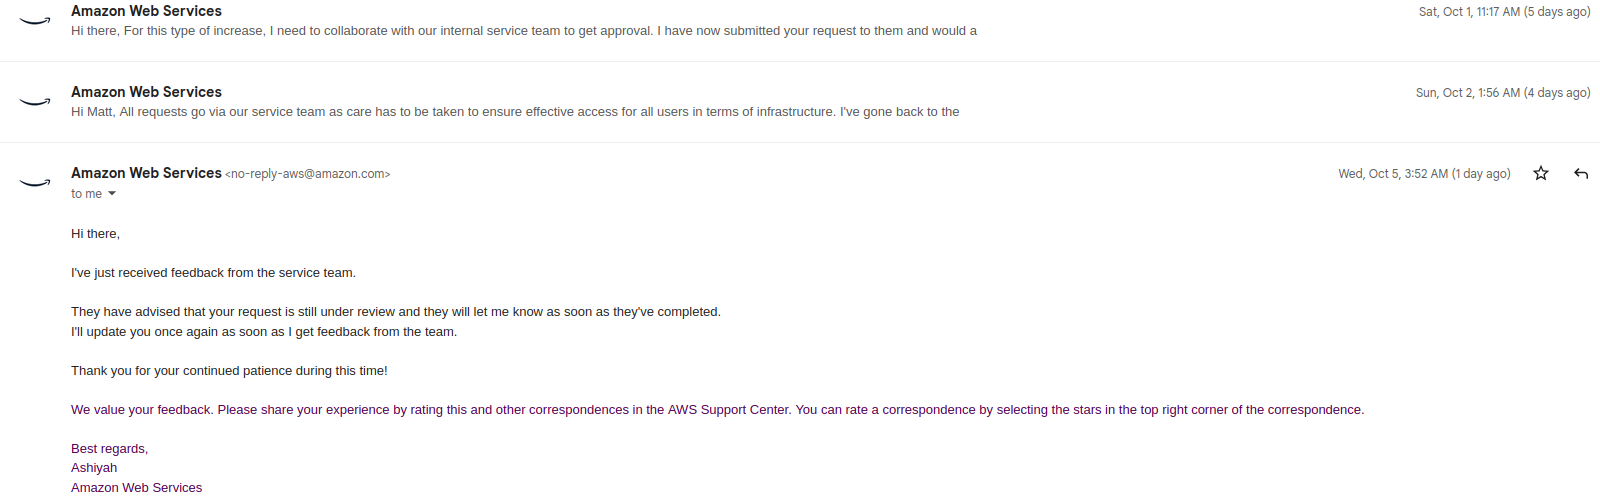

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from fight_classifier import DATASET_DIR, PROJECT_DIR

frames_dir = DATASET_DIR / 'raw_frames/'
videos_dir = DATASET_DIR / 'Peliculas/'

videos_df = pd.read_csv(videos_dir / 'videos.csv')

In [3]:
import pytorch_lightning as pl
from torchvision.models import MobileNet_V3_Large_Weights

from fight_classifier.data.image_dataset import ImageDataModule
from fight_classifier.model.image_based_model import \
    ProjFromFeatures
from fight_classifier.torch_module.image_classifier import \
    ImageClassifierModule

BATCH_SIZE = 40
SPLIT_COHERENCE_COL = 'fine_category'

frames_df = pd.read_csv(str(frames_dir / 'frames.csv'))

# We base our pre-processing on Mobilenet because it's the
# base of the model we will train in the next notebook.
base_model_weights = MobileNet_V3_Large_Weights.DEFAULT
preprocess = base_model_weights.transforms()
preprocess_kwargs = {
    'resize_size': preprocess.resize_size[0],
    'crop_size': preprocess.crop_size[0],
    'mean': preprocess.mean,
    'std': preprocess.std,
}

trainer = pl.Trainer(
    default_root_dir=str(PROJECT_DIR),
    max_epochs=10,
)


image_data_module = ImageDataModule(
    image_df=frames_df,
    batch_size=BATCH_SIZE,
    preprocess_kwargs=preprocess_kwargs,
    split_coherence_col=SPLIT_COHERENCE_COL,
    image_augmentation=False)
image_data_module.setup()
classifier = ProjFromFeatures(n_classes=2)
classif_module = ImageClassifierModule(classifier=classifier)

# Instead of training the model, we can load it from the checkpoint

# trainer.fit(
#    model=classif_module,
#    datamodule=image_data_module)

classif_module.load_from_checkpoint(
    str(PROJECT_DIR / 'checkpoints/epoch=9-step=2110.ckpt'),
    classifier=classifier,)

/home/matthieu/aviva/hiring-challenge/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/matthieu/aviva/hiring-challenge/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  ../c10/cuda/

ImageClassifierModule(
  (classifier): ProjFromFeatures(
    (base_model): MobileNetV3(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            )
          )
        )
     

# From images to videos

We use `ImageBasedVideoClassifier` to classify videos: we run the image classifier on every other image (to save computation time) and average them to get the video classification. Logically, since the image classifier's validation performance is almost perfect, the video classification is also almost perfect on the validation set.

In [ ]:
from albumentations.pytorch import ToTensorV2
import numpy as np
import sklearn
import skvideo.io
import torch
import tqdm

from fight_classifier.model.image_based_model import ImageBasedVideoClassifier

classifier.eval()
video_classifier = ImageBasedVideoClassifier(
    image_classifier=classifier)

predictions_probas = []
predictions = []
groundtruths = []


for _, video_row in tqdm.tqdm(videos_df.iterrows(), total=len(videos_df)):
    video_path = str(DATASET_DIR / video_row.video_path)
    video_fhwc = skvideo.io.vread(video_path)
    with torch.no_grad():
        frames_bhwc = torch.Tensor([
            image_data_module.train_dataset.preprocess_image(image_np)[1]
            for image_np in video_fhwc
        ])
        frames_bchw = torch.permute(frames_bhwc, (0, 3, 1, 2))
        video_proba = video_classifier(frames_bchw[None]).numpy()
        groundtruths.append(video_row.is_fight)
        predictions_probas.append(video_proba)
        predictions.append(np.argmax(video_proba))

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 185/197 [06:52<00:27,  2.28s/it]

# Metrics of video classification

Precision = 0.98
Recall = 1.00
F1-score = 0.99



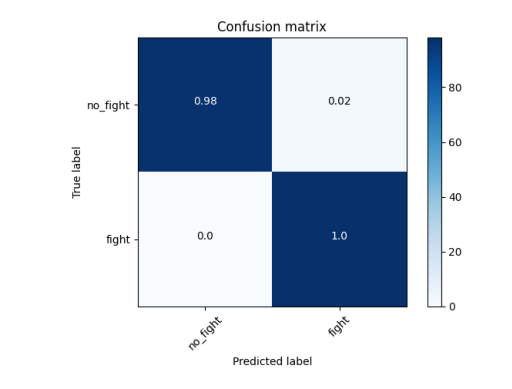

In [14]:
import matplotlib.pyplot as plt

from fight_classifier.visualization import imshow_chw
from fight_classifier.visualization.metrics import plot_confusion_matrix

confusion_matrix = sklearn.metrics.confusion_matrix(
    y_true=groundtruths, y_pred=predictions)
precision = confusion_matrix[1,1] / confusion_matrix[:,1].sum()
recall = confusion_matrix[1,1] / confusion_matrix[1,:].sum()
f1_score = 2 * precision * recall / (precision+recall)
print(
    f"Precision = {precision:.2f}\n"
    f"Recall = {recall:.2f}\n"
    f"F1-score = {f1_score:.2f}\n"
)
cm_viz_chw = plot_confusion_matrix(
    cm=confusion_matrix, class_names=['no_fight', 'fight'])
fig, ax = plt.subplots()
ax.set_axis_off()
imshow_chw(img_chw=cm_viz_chw)
plt.show()

# Activation map

I thought I would show some activation maps of the image model, thanks to Torch Cam. But I have some issues that I did not manage to solve.

In [4]:

from torchcam.methods import SSCAM

for example in image_data_module.train_dataset:
    cam = SSCAM(classifier)
    with torch.no_grad(): 
        out = classifier(input_tensor)
    cam(class_idx=1)

AttributeError: 'dict' object has no attribute 'shape'

# Failure to save with joblib

Another failure: I tried to save the model with joblib but could not debug it. I am unfamiliar with joblib and I am not sure it is the best way to export a torch model anyway.

In [6]:
import joblib
from fight_classifier import PROJECT_DIR

joblib_dump_path = str(PROJECT_DIR / 'joblib_image_classifier')
joblib.dump(value=classifier, filename=joblib_dump_path)

PicklingError: Can't pickle <function locate_candidate_layer.<locals>._record_output_shape at 0x7fd950f5ab90>: it's not found as torchcam.methods._utils.locate_candidate_layer.<locals>._record_output_shape